# Problem Statement: Human Activity Recognition Time Series Classification

## Import Libraries/Dataset

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
from pandas import read_csv
from numpy import dstack, unique, nan
from matplotlib import pyplot
from mpl_toolkits.mplot3d import axes3d
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Conv1D, MaxPool1D
from keras.utils import to_categorical

In [3]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
if tf.test.gpu_device_name(): 

    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=bbb3920eaaa15878cd5aad1655d8527a484fe3ccd3a9e4204223a49b5408a966
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Default GPU Device: /device:GPU:0
Gen RAM Free: 12.2 GB  | Proc size: 1.1 GB
GPU RAM Free: 15921MB | Used: 359MB | Util   2% | Total 16280MB


In [4]:
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values
 
data = load_file('/content/gdrive/MyDrive/HARDataset/train/InertialSignals/total_acc_y_train.txt')
print(data)

[[-0.1232167 -0.1268756 -0.1240037 ... -0.1240696 -0.1227451 -0.121326 ]
 [-0.123976  -0.1268078 -0.1277862 ... -0.1290268 -0.1264244 -0.1305193]
 [-0.1200157 -0.1214994 -0.1228407 ... -0.1308757 -0.1312099 -0.1301826]
 ...
 [-0.1711829 -0.1999375 -0.2319457 ... -0.2217656 -0.2811496 -0.3275988]
 [-0.223801  -0.2210407 -0.1839923 ... -0.1620087 -0.2020367 -0.2291273]
 [-0.3060512 -0.2666046 -0.2053607 ... -0.3977751 -0.3492473 -0.3323721]]


## Data Pre-processing 

In [5]:
# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
# load the total acc data
filenames = ['total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']
total_acc = load_group(filenames, prefix='/content/gdrive/MyDrive/HARDataset/train/InertialSignals/')
print(total_acc.shape)

(7352, 128, 3)


In [6]:
# load a dataset group, such as train or test
def load_dataset(group, prefix=''):
	filepath = prefix + group + '/InertialSignals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y
# load all train
trainX, trainy = load_dataset('train', '/content/gdrive/MyDrive/HARDataset/')
print(trainX.shape, trainy.shape)
# load all test
testX, testy = load_dataset('test', '/content/gdrive/MyDrive/HARDataset/')
print(testX.shape, testy.shape)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)


## Data Visualization

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


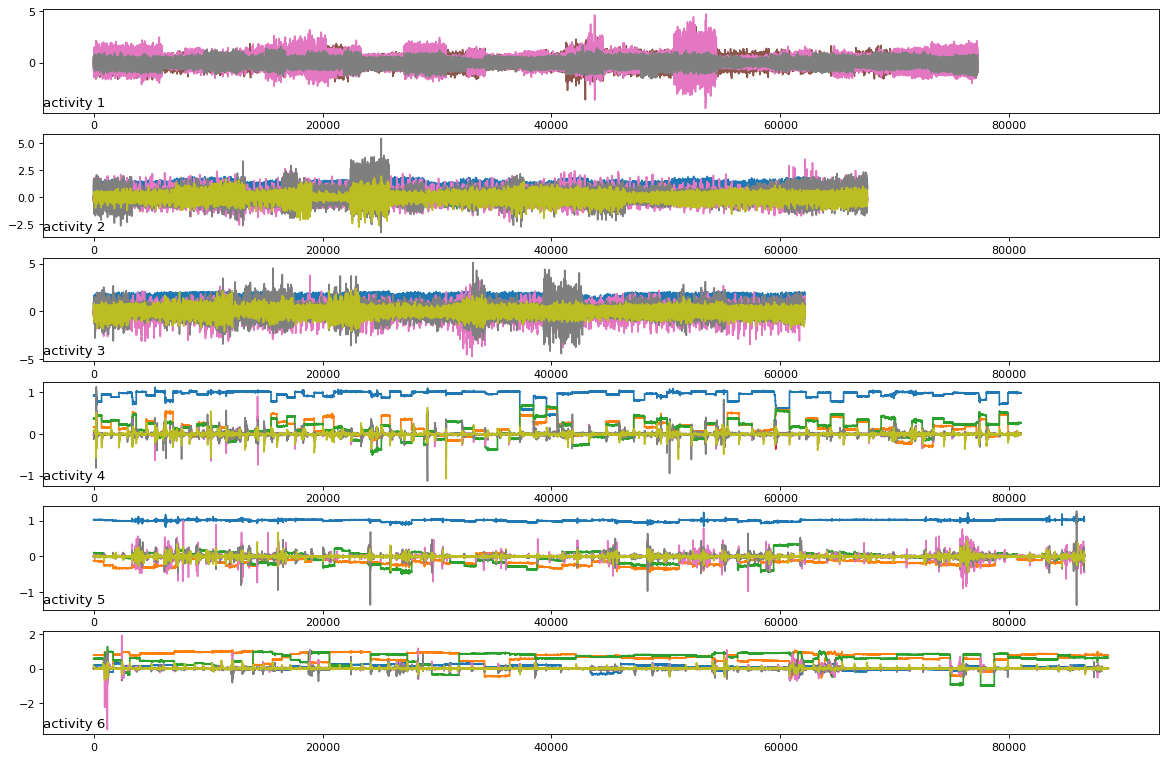

In [7]:
# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
    # get row indexes for the subject id
    ix = [i for i in range(len(sub_map)) if sub_map[i] == sub_id]
    # return the selected samples
    return X[ix, :, :], y[ix]


# convert a series of windows to a 1D list
def to_series(windows):
    series = list()
    for window in windows:
        # remove the overlap from the window
        half = int(len(window) / 2) - 1
        for value in window[-half:]:
            series.append(value)
    return series


# group data by activity
def data_by_activity(X, y, activities):
    # group windows by activity
    return {a: X[y[:, 0] == a, :, :] for a in activities}


# plot histograms for each activity for a subject
def plot_activity(X, y):
    # get a list of unique activities for the subject
    activity_ids = unique(y[:, 0])
    # group windows by activity
    grouped = data_by_activity(X, y, activity_ids)
    # plot per activity, histograms for each axis
    pyplot.figure(figsize=(18, 12), dpi=80, facecolor='w', edgecolor='k')
    xaxis = None
    for k in range(len(activity_ids)):
        act_id = activity_ids[k]
        # total acceleration
        for i in range(9):
            ax = pyplot.subplot(len(activity_ids), 1, k + 1, sharex=xaxis)
            #ax.set_xlim(-1, 1)
            if k == 0 and i == 0:
                xaxis = ax
            pyplot.plot(to_series(grouped[act_id][:, :, i]))
            pyplot.title('activity ' + str(act_id), y=0, loc='left')
    pyplot.show()


# load data
trainX, trainy = load_dataset('train', '/content/gdrive/MyDrive/HARDataset/')
# load mapping of rows to subjects
sub_map = load_file('/content/gdrive/MyDrive/HARDataset/train/subject_train.txt')
train_subjects = unique(sub_map)
# get the data for one subject
sub_id = train_subjects[0]
subX, suby = data_for_subject(trainX, trainy, sub_map, sub_id)
# plot data for subject
plot_activity(trainX, trainy)

## Model

### Model 1: Develop an LSTM Network Model

In [8]:
n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

In [24]:
modelLSTM = Sequential()
# define LSTM model
modelLSTM.add(LSTM(100, input_shape=(n_timesteps,n_features), return_sequences=True))
modelLSTM.add(Dropout(0.3))
modelLSTM.add(LSTM(100))
modelLSTM.add(Dense(120, activation='relu'))
modelLSTM.add(Dense(7, activation='softmax'))
modelLSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Reason for the choice of learning rate and its value : Upon choosing the default Learning rate, best accuracy for data was acheived for the adam optimizer.

In [25]:
# train the model
import time
start_time = time.time()
# fit network
hLSTM = modelLSTM.fit(trainX, to_categorical(trainy), epochs=15, batch_size=64)
print("--- %s seconds taken for training---" % (time.time() - start_time))

Epoch 1/15
115/115 [==============================] - 5s 18ms/step - loss: 1.3349 - accuracy: 0.4455
Epoch 2/15
115/115 [==============================] - 2s 18ms/step - loss: 0.5944 - accuracy: 0.7433
Epoch 3/15
115/115 [==============================] - 2s 18ms/step - loss: 0.3416 - accuracy: 0.8784
Epoch 4/15
115/115 [==============================] - 2s 18ms/step - loss: 0.2137 - accuracy: 0.9239
Epoch 5/15
115/115 [==============================] - 2s 18ms/step - loss: 0.1664 - accuracy: 0.9338
Epoch 6/15
115/115 [==============================] - 2s 18ms/step - loss: 0.1466 - accuracy: 0.9460
Epoch 7/15
115/115 [==============================] - 2s 18ms/step - loss: 0.1428 - accuracy: 0.9396
Epoch 8/15
115/115 [==============================] - 2s 18ms/step - loss: 0.1487 - accuracy: 0.9413
Epoch 9/15
115/115 [==============================] - 2s 18ms/step - loss: 0.1148 - accuracy: 0.9503
Epoch 10/15
115/115 [==============================] - 2s 18ms/step - loss: 0.1095 - accura

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 128, 100)          44000     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 100)          0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_8 (Dense)              (None, 120)               12120     
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 847       
Total params: 137,367
Trainable params: 137,367
Non-trainable params: 0
_________________________________________________________________
Final training loss 	 0.12221819162368774
Final training accuracy  0.9479053616523743


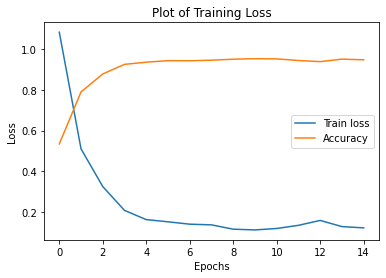

In [26]:
modelLSTM.summary()

print('Final training loss \t', hLSTM.history['loss'][-1])
print('Final training accuracy ', hLSTM.history['accuracy'][-1])

# plot the training loss
plt.plot(hLSTM.history['loss'], label='Train loss')
plt.plot(hLSTM.history['accuracy'], label='Accuracy') 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Plot of Training Loss')
plt.legend()
plt.show()

In [27]:
testLoss_LSTM, testAccuracy_LSTM = modelLSTM.evaluate( testX, to_categorical(testy))
# model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print('Testing loss \t', testLoss_LSTM)
print('Testing accuracy ', testAccuracy_LSTM)


prediction = modelLSTM.predict_classes(testX)
print(confusion_matrix(testy,prediction))
print(classification_report(testy,prediction))

93/93 [==============================] - 1s 8ms/step - loss: 0.2633 - accuracy: 0.9141
Testing loss 	 0.2633024752140045
Testing accuracy  0.9141499996185303


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[469   9  14   0   4   0]
 [  1 463   7   0   0   0]
 [  0   1 419   0   0   0]
 [  4   4   0 370 113   0]
 [  2   0   0  67 463   0]
 [  0  27   0   0   0 510]]
              precision    recall  f1-score   support

           1       0.99      0.95      0.97       496
           2       0.92      0.98      0.95       471
           3       0.95      1.00      0.97       420
           4       0.85      0.75      0.80       491
           5       0.80      0.87      0.83       532
           6       1.00      0.95      0.97       537

    accuracy                           0.91      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.91      0.91      2947



### Model 2: Develop a CNN-LSTM Network Model 

In [ ]:
trainX = trainX.reshape(7352, 128, 9, 1)
testX = testX.reshape(2947, 128, 9, 1)

In [ ]:
model = Sequential()
# define CNN model
model.add(TimeDistributed(Conv1D(filters=256, kernel_size=(3), activation = 'relu', input_shape=(128, 9, 1))))
model.add(TimeDistributed(MaxPool1D(pool_size=(2))))
model.add(TimeDistributed(Flatten()))
# define LSTM model
model.add(LSTM(90))
model.add(Dense(120), activation='relu')
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Reason for the choice of learning rate and its value : Upon choosing the default Learning rate, best accuracy for data was acheived for the adam optimizer.

In [ ]:
# train the model
import time
start_time = time.time()
h = model.fit(trainX, to_categorical(trainy), epochs=7, batch_size=64)
print("--- %s seconds taken for training---" % (time.time() - start_time))

Epoch 1/7
115/115 [==============================] - 5s 29ms/step - loss: 1.0676 - accuracy: 0.5978
Epoch 2/7
115/115 [==============================] - 3s 28ms/step - loss: 0.4093 - accuracy: 0.8365
Epoch 3/7
115/115 [==============================] - 3s 28ms/step - loss: 0.2772 - accuracy: 0.9008
Epoch 4/7
115/115 [==============================] - 3s 28ms/step - loss: 0.2108 - accuracy: 0.9216
Epoch 5/7
115/115 [==============================] - 3s 28ms/step - loss: 0.1511 - accuracy: 0.9370
Epoch 6/7
115/115 [==============================] - 3s 28ms/step - loss: 0.1418 - accuracy: 0.9412
Epoch 7/7
115/115 [==============================] - 3s 28ms/step - loss: 0.1330 - accuracy: 0.9473
--- 24.386091709136963 seconds taken for training---


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 128, 7, 256)       1024      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 128, 3, 256)       0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 128, 768)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 90)                309240    
_________________________________________________________________
dense_2 (Dense)              (None, 120)               10920     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 847       
Total params: 322,031
Trainable params: 322,031
Non-trainable params: 0
________________________________________________

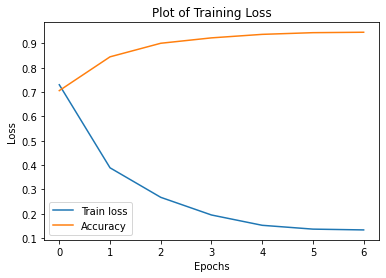

In [ ]:
model.summary()

print('Final training loss \t', h.history['loss'][-1])
print('Final training accuracy ', h.history['accuracy'][-1])

# plot the training loss
plt.plot(h.history['loss'], label='Train loss')
plt.plot(h.history['accuracy'], label='Accuracy') 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Plot of Training Loss')
plt.legend()
plt.show()

In [ ]:
# testX = testX.reshape(2947, 128, 9, 1)
testLoss, testAccuracy = model.evaluate( testX, to_categorical(testy))

print('Testing loss \t', testLoss)
print('Testing accuracy ', testAccuracy)


prediction = model.predict_classes(testX)
print(confusion_matrix(testy,prediction))
print(classification_report(testy,prediction))

93/93 [==============================] - 1s 6ms/step - loss: 0.4094 - accuracy: 0.8829
Testing loss 	 0.4094060957431793
Testing accuracy  0.8829317688941956


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[405  67  24   0   0   0]
 [ 33 423  15   0   0   0]
 [  1  11 408   0   0   0]
 [  1   2   0 359 106  23]
 [  1   3   0  57 471   0]
 [  0   1   0   0   0 536]]
              precision    recall  f1-score   support

           1       0.92      0.82      0.86       496
           2       0.83      0.90      0.87       471
           3       0.91      0.97      0.94       420
           4       0.86      0.73      0.79       491
           5       0.82      0.89      0.85       532
           6       0.96      1.00      0.98       537

    accuracy                           0.88      2947
   macro avg       0.88      0.88      0.88      2947
weighted avg       0.88      0.88      0.88      2947

